# 第四题：神经网络：三层感知机

实现内容：
1. 实现一个三层感知机
2. 对手写数字数据集进行分类
3. 绘制损失值变化曲线
4. 完成kaggle MNIST手写数字分类任务，根据给定的超参数训练模型，完成表格的填写

在这道题中，我们要实现一个三层感知机

<img src="https://davidham3.github.io/blog/2018/09/11/logistic-regression/Fig2.png" ,width=600>

## 前向传播

我们实现一个最简单的三层感知机，一个输入层，一个隐藏层，一个输出层，隐藏层单元个数为$h$个，输出层有$K$个单元。

1. 我们将第一层的输入，定义为$X \in \mathbb{R}^{n \times m}$，n个样本，m个特征。  
2. 输入层到隐藏层之间的权重(weight)与偏置(bias)，分别为$W_1 \in \mathbb{R}^{m \times h}$，$b_1 \in \mathbb{R}^{1 \times h}$。  
3. 隐藏层到输出层的权重和偏置分为别$W_2 \in \mathbb{R}^{h \times K}$，$b_2 \in \mathbb{R}^{1 \times K}$。

隐藏层的激活函数选用ReLU

$$
\mathrm{ReLU}(x) = \max (0, x)
$$

我们用$H_1$表示第一个隐藏层的输出值，$O$表示输出层的输出值，这样，前向传播即可定义为

$$
Z = XW_1 + b_1\\
H_1 = \mathrm{ReLU}(Z)\\
O = H_1 W_2 + b_2
$$

其中，$H_1 \in \mathbb{R}^{n \times h}$，$O \in \mathbb{R}^{n \times K}$。

**注意：这里我们其实是做了广播，将$b_1$复制了$n-1$份后拼接成了维数为$n \times h$的矩阵，同理，$b_2$也做了广播，拼成了$n \times K$的矩阵。**

最后一层的输出，使用softmax函数激活，得到神经网络计算出的各类的概率值：

$$
\begin{aligned}
\hat{y_i} & = \mathrm{softmax}(O_i)\\
& = \frac{\exp{(O_i)}}{\sum^{K}_{k=1} \exp{(O_k)}}
\end{aligned}
$$

其中，$\hat{y_i}$表示第$i$类的概率值，也就是输出层第$i$个神经元经$\mathrm{softmax}$激活后的值。

## 损失函数

损失函数使用交叉熵损失函数：
$$\mathrm{cross\_entropy}(y, \hat{y}) = -\sum^{K}_{k=1}y_k \log{(\hat{y_k})}$$

这样，$n$个样本的平均损失为：
$$
\mathrm{loss} = - \frac{1}{n} \sum_n \sum^{K}_{k=1} y_k \log{(\hat{y_k})}
$$

**注意，这里我们的提到的$\log$均为$\ln$，在numpy中为**`np.log`

## 反向传播

我们使用梯度下降训练模型，求解方式就是求出损失函数对参数的偏导数，即参数的梯度，然后将参数减去梯度乘以学习率，进行参数的更新。
$$
W := W - \alpha \frac{\partial \mathrm{loss}}{\partial W}
$$
其中，$\alpha$是学习率。

在这道题中，交叉熵损失函数的求导比较麻烦，我们先求神经网络的输出层的偏导数，写成链式法则的形式：

$$
\frac{\partial \mathrm{loss}}{\partial O_i} = \frac{\partial \mathrm{loss}}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial O_i}
$$

首先求解第一项：
$$
\frac{\partial \mathrm{loss}}{\partial \hat{y}} = - \frac{1}{n} \sum_n \sum^{K}_{k=1} y_k \frac{1}{\hat{y_k}}
$$

然后求解第二项，因为$\hat{y_k}$的分母是$\sum_k \exp{(O_k)}$，里面包含$O_i$，所以每一个$\hat{y_k}$的分母都包含$O_i$，这就要求反向传播的时候需要考虑这$K$项，将这$K$项的偏导数加在一起。

这$K$项分别为：$\frac{\exp{(O_1)}}{\sum_k \exp{(O_k)}}$，$\frac{\exp{(O_2)}}{\sum_k \exp{(O_k)}}$，...，$\frac{\exp{(O_i)}}{\sum_k \exp{(O_k)}}$，...，$\frac{\exp{(O_k)}}{\sum_k \exp{(O_k)}}$。

显然，这里只有分子带有$O_i$的这项与其他的项不同，因为分子和分母同时包含了$O_i$，而其他的项只有分母包含了$O_i$。

这就需要在求解$\frac{\partial \hat{y}}{\partial O_i}$的时候分两种情况讨论
1. 分子带$O_i$
2. 分子不带$O_i$

第一种情况，当分子含有$O_i$时：

$$
\begin{aligned}
\frac{\partial \hat{y_i}}{\partial O_i} & = \frac{\partial \hat{y_i}}{\partial O_i}\\
& = \frac{\exp{(O_i)} (\sum^{K}_{k=1} \exp{(O_k)}) - (\exp{(O_i)})^2 }{(\sum^{K}_{k=1} \exp{(O_k)})^2}\\
& = \frac{\exp{(O_i)}}{\sum^{K}_{k=1} \exp{(O_k)}} \frac{\sum^{K}_{k=1} \exp{(O_k)} - \exp{(O_i)}}{\sum^{K}_{k=1} \exp{(O_k)}}\\
& = \hat{y_i} ( 1 - \hat{y_i} )
\end{aligned}
$$

第二种情况，当分子不含$O_i$时，我们用$j$表示当前项的下标：

$$
\begin{aligned}
\frac{\partial \hat{y_j}}{\partial O_i} & = \frac{- \exp{(O_j)} \exp{(O_i)}}{(\sum^{K}_{k=1} \exp{(O_k)})^2}\\
& = - \hat{y_j} \hat{y_i}
\end{aligned}
$$

这样，$\mathrm{loss}$对$O_i$的偏导数即为：
$$\begin{aligned}
\frac{\partial \mathrm{loss}}{\partial O_i} & = \frac{\partial \mathrm{loss}}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial O_i}\\
& = (- \frac{1}{n} \sum_n \sum^{K}_{k=1} y_k \frac{1}{\hat{y_k}}) \frac{\partial \hat{y}}{\partial O_i}\\
& = - \frac{1}{n} \sum_n (y_i \frac{1}{\hat{y_i}} \hat{y_i} ( 1 - \hat{y_i} ) + \sum^K_{k \not= i} y_k \frac{1}{\hat{y_k}}( - \hat{y_k} \hat{y_i}))\\
& = - \frac{1}{n} \sum_n ( y_i - y_i \hat{y_i} - \sum^K_{k \not= i} y_k \hat{y_i})\\
& = - \frac{1}{n} \sum_n ( y_i  - \hat{y_i} \sum^K_{k = 1} y_k )
\end{aligned}
$$

由于我们处理的多类分类任务，一个样本只对应一个标记，所以$\sum^K_{k = 1} y_k = 1$，上式在这种问题中，即可化简为：

$$\begin{aligned}
\frac{\partial \mathrm{loss}}{\partial O_i} &= - \frac{1}{n} \sum_n ( y_i  - \hat{y_i})\\
& = \frac{1}{n} \sum_n (\hat{y_i} -  y_i)
\end{aligned}
$$

将其写成矩阵表达式：

$$\begin{aligned}
\frac{\partial \mathrm{loss}}{\partial O} &= \frac{1}{n} (\hat{y} - y)
\end{aligned}
$$

也就是说，我们的损失函数对输出层的$K$个神经单元的偏导数为$\mathrm{softmax}$激活值减去真值。

接下来我们需要求损失函数对参数$W_2$和$b_2$的偏导数

$$
\begin{aligned}
\frac{\partial loss}{\partial W_2} & = \frac{\partial \mathrm{loss}}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial O} \frac{\partial O}{\partial W_2}\\
& = \frac{\partial loss}{\partial O} \frac{\partial O}{\partial W_2}\\
& = \frac{1}{n} (\hat{y} - y) \frac{\partial O}{\partial W_2}\\
& = \frac{1}{n} [{H_1}^\mathrm{T} (\hat{y} - y)]
\end{aligned}
$$

$$
\begin{aligned}
\frac{\partial loss}{\partial b_2} & = \frac{\partial \mathrm{loss}}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial O} \frac{\partial O}{\partial b_2}\\
& = \frac{\partial loss}{\partial O} \frac{\partial O}{\partial b_2}\\
& = \frac{1}{n} (\hat{y} - y) \frac{\partial O}{\partial b_2}\\
& = \frac{1}{n} \sum^n_{i=1} (\hat{y_i} - y_i)
\end{aligned}
$$

其中，$\frac{\partial loss}{\partial W_2} \in \mathbb{R}^{h \times K}$，$\frac{\partial loss}{\partial b_2} \in \mathbb{R}^{1 \times K}$。  
**注意，由于$b_2$是被广播成$n \times K$的矩阵，因此实际上$b_2$对每个样本的损失都有贡献，因此对其求偏导时，要把$n$个样本对它的偏导数加和。**

同理，我们可以求得$\mathrm{loss}$对$W_1$和$b_1$的偏导数：

$$
\begin{aligned}
\frac{\partial loss}{\partial W_1} & = \frac{\partial \mathrm{loss}}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial O} \frac{\partial O}{\partial H_1} \frac{\partial H_1}{\partial Z} \frac{\partial Z}{\partial W_1}\\
& = \frac{\partial loss}{\partial O} \frac{\partial O}{\partial H_1} \frac{\partial H_1}{\partial Z} \frac{\partial Z}{\partial W_1}\\
& = \frac{1}{n} {X}^\mathrm{T} [(\hat{y} - y) {W_2}^\mathrm{T} \frac{\partial H_1}{\partial Z}]\\
\end{aligned}
$$

由于我们使用的是$\mathrm{ReLU}$激活函数，它的偏导数为：

$$\frac{\partial \mathrm{ReLU(x)}}{\partial x} = 
\begin{cases}
0 & \text{if } x < 0\\
1 & \text{if } x \geq 0
\end{cases}
$$

所以上式为：

$$
\frac{\partial loss}{\partial {W_1}_{ij}} =
\begin{cases}
0 & \text{if } {Z}_{ij} < 0\\
    \frac{1}{n} {X}^\mathrm{T} (\hat{y} - y) {W_2}^\mathrm{T} & \text{if } {Z}_{ij} \geq 0
\end{cases}
$$

其中，${W_1}_{ij}$表示矩阵$W_1$第$i$行第$j$列的值，${Z}_{ij}$表示矩阵$Z$第$i$行第$j$列的值。  
同理：

$$
\begin{aligned}
\frac{\partial loss}{\partial b_1} & = \frac{\partial \mathrm{loss}}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial O} \frac{\partial O}{\partial H_1} \frac{\partial H_1}{\partial Z} \frac{\partial Z}{\partial b_1}\\
& = \frac{\partial loss}{\partial O} \frac{\partial O}{\partial H_1} \frac{\partial H_1}{\partial Z} \frac{\partial Z}{\partial b_1}\\
& = \frac{1}{n} (\hat{y} - y) {W_2}^\mathrm{T} \frac{\partial H_1}{\partial Z}\\
& = \begin{cases}
0 &\text{if } {Z}_{ij} < 0\\
\frac{1}{n} \sum_n (\hat{y} - y) {W_2}^\mathrm{T} &\text{if } {Z}_{ij} \geq 0
\end{cases}
\end{aligned}
$$

其中，$\frac{\partial loss}{\partial W_1} \in \mathbb{R}^{m \times h}$，$\frac{\partial loss}{\partial b_1} \in \mathbb{R}^{1 \times h}$。

## 参数更新

求得损失函数对四个参数的偏导数后，我们就可以使用梯度下降进行参数更新：
$$
W_2 := W_2 - \alpha \frac{\partial \mathrm{loss}}{\partial W_2}\\
b_2 := b_2 - \alpha \frac{\partial \mathrm{loss}}{\partial b_2}\\
W_1 := W_1 - \alpha \frac{\partial \mathrm{loss}}{\partial W_1}\\
b_1 := b_1 - \alpha \frac{\partial \mathrm{loss}}{\partial b_1}\\
$$
其中，$\alpha$是学习率

以上内容，就是一个三层感知机的前向传播与反向传播过程。

## 1. 导入数据

使用第一题的手写数字数据集

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from time import time

In [3]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

40%做测试集，60%做训练集

In [4]:
trainX, testX, trainY, testY = train_test_split(load_digits()['data'], load_digits()['target'], test_size = 0.4, random_state = 32)

In [5]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((1078, 64), (1078,), (719, 64), (719,))

## 2. 数据预处理

使用和第一题一样的标准化处理方法

In [6]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
trainX = s.fit_transform(trainX)
testX = s.transform(testX)

接下来还要处理输出。  
我们的神经网络是针对每个样本，输出其分别属于$K$类的概率，我们要找最大的那个概率，对应的是哪个类。  
我们当前的trainY和testY，每个样本都是一个类标，我们需要将其变成one_hot编码，也就是，假设当前样本的类别是3，我们需要把它变成一个长度为10的向量，其中第4个元素为1，其他元素都为0。得到的矩阵分别记为trainY_mat和testY_mat。  
这样，模型训练完成后，会针对每个样本输出十个数，分别代表这个样本属于$0,1,...,9$的概率，那我们只要取最大的那个数的下标，就知道模型认为这个样本是哪类了。

In [7]:
trainY_mat = np.zeros((len(trainY), 10))
trainY_mat[np.arange(0, len(trainY), 1), trainY] = 1

testY_mat = np.zeros((len(testY), 10))
testY_mat[np.arange(0, len(testY), 1), testY] = 1

In [8]:
trainY_mat.shape, testY_mat.shape

((1078, 10), (719, 10))

## 3. 参数初始化

这题和上一题的区别是，我们把参数用dict存起来

In [9]:
def initialize(h, K):
    '''
    参数初始化
    
    Parameters
    ----------
    h: int: 隐藏层单元个数
    
    K: int: 输出层单元个数
    
    Returns
    ----------
    parameters: dict，参数，键是"W1", "b1", "W2", "b2"
    
    '''
    np.random.seed(32)
    W_1 = np.random.normal(size = (trainX.shape[1], h)) * 0.01
    b_1 = np.zeros((1, h))
    
    np.random.seed(32)
    W_2 = np.random.normal(size = (h, K)) * 0.01
    b_2 = np.zeros((1, K))
    
    parameters = {'W1': W_1, 'b1': b_1, 'W2': W_2, 'b2': b_2}
    
    return parameters

In [10]:
# 测试样例
parameterst = initialize(50, 10)
print(parameterst['W1'].shape) # (64, 50)
print(parameterst['b1'].shape) # (1, 50)
print(parameterst['W2'].shape) # (50, 10)
print(parameterst['b2'].shape) # (1, 10)

(64, 50)
(1, 50)
(50, 10)
(1, 10)


## 4. 前向传播

完成Z的计算

In [11]:
def linear_combination(X, W, b):
    '''
    计算Z，Z = XW + b
    
    Parameters
    ----------
    X: np.ndarray, shape = (n, m)，输入的数据
    
    W: np.ndarray, shape = (m, h)，权重
    
    b: np.ndarray, shape = (1, h)，偏置
    
    Returns
    ----------
    Z: np.ndarray, shape = (n, h)，线性组合后的值
    
    '''
    
    # Z = XW + b
    # YOUR CODE HERE
    Z = np.matmul(X, W) + b    
    return Z

In [12]:
# 测试样例
parameterst = initialize(50, 10)
Zt = linear_combination(trainX, parameterst['W1'], parameterst['b1'])
print(Zt.shape) # (1078, 50)
print(Zt.mean()) # -5.27304442123e-19

(1078, 50)
-5.93217497388e-19


$\rm ReLU$激活函数

In [13]:
def ReLU(X):
    '''
    ReLU激活函数
    
    Parameters
    ----------
    X: np.ndarray，待激活的矩阵
    
    Returns
    ----------
    activations: np.ndarray, 激活后的矩阵
    
    '''
    
    # YOUR CODE HERE
    activations = X.copy()
    n, m = activations.shape
    for i in range(n):
        for j in range(m):
            if activations[i, j] < 0:
                activations[i, j] = 0
    
    return activations

In [14]:
# 测试样例
parameterst = initialize(50, 10)
Zt = linear_combination(trainX, parameterst['W1'], parameterst['b1'])
Ht = ReLU(Zt)
print(Ht.mean()) # 0.0304

Ot = linear_combination(Ht, parameterst['W2'], parameterst['b2'])
print(Ot.shape) # (1078, 10)
print(Ot.mean()) # 0.0006

0.0304456709206
(1078, 10)
0.000600192658464


$\rm softmax$激活  

$$
\mathrm{softmax}(O_i) = \frac{\exp{(O_i)}}{\sum^{K}_{k=1} \exp{(O_k)}}
$$

In [15]:
def my_softmax(O):
    '''
    softmax激活
    '''
    # YOUR CODE HERE
    
    """
    activations = O.copy()
    n, m = O.shape
    
    for i in range(n):
        for j in range(m):
            activations[i, j] = np.exp(activations[i, j]) / sum
    """
    activations = O.copy()
    
    n = len(O)
    
    for i in range(n):
        activations[i] = np.exp(activations[i]) / np.sum(np.exp(activations[i]))
    
    return activations

In [16]:
# 测试样例1
print(my_softmax(np.array([[0.3, 0.3, 0.3]])))  # array([[ 0.33333333,  0.33333333,  0.33333333]])

# 测试样例2
test1 = np.array([[-1e32, -1e32, -1e32]])
test2 = np.array([[1e32, 1e32, 1e32]])
print(my_softmax(test1))
print(my_softmax(test2))

[[ 0.33333333  0.33333333  0.33333333]]
[[ nan  nan  nan]]
[[ nan  nan  nan]]


/Users/yangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/yangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


这里，其实是有数值计算上的问题的，假设，我们最后的输出有三个数，每个数都特别小，理论上来说，通过$\rm softmax$激活后，三个值都是$\frac{1}{3}$。但实际上就不是这样了，实际上会导致分母为0，除法就不能做了。如果每个数都特别大，会导致做指数运算的时候上溢。

我们需要用其他的方法来实现$\rm softmax$。

我们将传入$\rm softmax$的向量，每个元素减去他们中的最大值，即

$$
\mathrm{softmax}(O_i) = \mathrm{softmax}(O_i - \mathrm{max(O)})
$$

这个式子是成立的，感兴趣的同学可以证明一下上面的式子。

当我们做了这样的变换后，向量$O$中的最大值就变成了0，就不会上溢了，而分母中最少有一项为1，也不会出现下溢导致分母为0的问题了。

In [17]:
def softmax(O):
    '''
    softmax激活函数
    
    Parameters
    ----------
    O: np.ndarray，待激活的矩阵
    
    Returns
    ----------
    activations: np.ndarray, 激活后的矩阵
    
    '''
    
    # YOUR CODE HEER

    temp = O.copy()

    matrix_max = np.max(O)

    temp -= matrix_max
    
    return my_softmax(temp)

In [18]:
# 测试样例
parameterst = initialize(50, 10)
Zt = linear_combination(trainX, parameterst['W1'], parameterst['b1'])
Ht = ReLU(Zt)
Ot = linear_combination(Ht, parameterst['W2'], parameterst['b2'])
y_pred = softmax(Ot)

print(y_pred.shape)  # (1078, 10)
print(Ot.mean())     # 0.000600192658464
print(y_pred.mean()) # 0.1

(1078, 10)
0.000600192658464
0.1


接下来是实现损失函数，交叉熵损失函数：

$$
\mathrm{loss} = - \frac{1}{n} \sum_n \sum^{K}_{k=1} y_k \log{(\hat{y_k})}
$$

这里又会出一个问题，交叉熵损失函数中，我们需要对$\rm softmax$的激活值取对数，也就是$\log{\hat{y}}$，这就要求我们的激活值全都是大于0的数，不能等于0，但是我们实现的$\rm softmax$在有些时候确实会输出0，比如：

In [19]:
softmax(np.array([[1e32, 0, -1e32]]))

array([[ 1.,  0.,  0.]])

这就使得在计算loss的时候会出现问题，解决这个问题的方法是$\rm log \ softmax$。所谓$\rm log \ softmax$，就是将交叉熵中的对数运算与$\rm softmax$结合起来，避开为0的情况

$$\begin{aligned}
\log{\frac{\exp{(O_i)}}{\sum_K \exp{(O_k)}}} &= \log{\frac{\exp{(O_i - \mathrm{max}(O))}}{\sum_K \exp{(O_k - \mathrm{max}(O))}}}\\
&= O_i - \mathrm{max}(O) - \log{\sum_K \exp{(O_k - \mathrm{max}(O))}}
\end{aligned}
$$

这样我们再计算$\rm loss$的时候就可以把输出层的输出直接放到$\rm log \ softmax$中计算，不用先激活，再取对数了。

我们先编写`log_softmax`

In [20]:
def log_softmax(x):
    '''
    log softmax
    
    Parameters
    ----------
    x: np.ndarray，待激活的矩阵
    
    Returns
    ----------
    log_activations: np.ndarray, 激活后取了对数的矩阵
    
    '''
    # YOUR CODE HERE
    matrix_max = np.max(x)
    log_activations = x.copy()
    n = len(x)
    for i in range(n):
        log_activations[i] = log_activations[i] - matrix_max - np.log(np.sum(np.exp(log_activations[i] - matrix_max)))

    
    return log_activations

In [21]:
# 测试样例
parameterst = initialize(50, 10)
Zt = linear_combination(trainX, parameterst['W1'], parameterst['b1'])
Ht = ReLU(Zt)
Ot = linear_combination(Ht, parameterst['W2'], parameterst['b2'])

t = log_softmax(Ot)
print(t.shape)  # (1078, 10)
print(t.mean()) # -2.30259148717

(1078, 10)
-2.30259148717


然后编写`cross_entropy_with_softmax`

In [22]:
def cross_entropy_with_softmax(y_true, O):
    '''
    求解交叉熵损失函数，这里需要使用log softmax，所以参数分别是真值和未经softmax激活的输出值

    Parameters
    ----------
    y_true: np.ndarray，shape = (n, K), 真值
    
    O: np.ndarray, shape = (n, K)，softmax激活前的输出层的输出值
    
    Returns
    ----------
    loss: float, 平均的交叉熵损失值
    
    '''
    
    # 平均交叉熵损失
    # YOUR CODE HERE
    log_activations = log_softmax(O)
    n, m = y_true.shape
    loss = 0
    for i in range(n):
        for j in range(m):
            loss += y_true[i, j] * log_activations[i, j]
    
    return (-1 / n) * loss

In [23]:
# 测试样例
parameterst = initialize(50, 10)
Zt = linear_combination(trainX, parameterst['W1'], parameterst['b1'])
Ht = ReLU(Zt)
Ot = linear_combination(Ht, parameterst['W2'], parameterst['b2'])
losst = cross_entropy_with_softmax(trainY_mat, Ot)

print(losst.mean()) # 2.30266707958

2.30266707958


**正是因为$\rm softmax$激活与交叉熵损失会有这样的问题，所以在很多深度学习框架中，交叉熵损失函数就直接带有了激活的功能，所以我们在实现前向传播计算的时候，就不要加$\rm softmax$激活函数了。**

In [24]:
def forward(X, parameters):
    '''
    前向传播，从输入一直到输出层softmax激活前的值
    
    Parameters
    ----------
    X: np.ndarray, shape = (n, m)，输入的数据
    
    parameters: dict，参数
    
    Returns
    ----------
    O: np.ndarray, shape = (n, K)，softmax激活前的输出层的输出值
    
    '''
    # 输入层到隐藏层
    # YOUR CODE HERE
    Z = linear_combination(X, parameters['W1'], parameters['b1'])
    
    # 隐藏层的激活
    # YOUR CODE HERE
    H = ReLU(Z)
    
    # 隐藏层到输出层
    # YOUR CODE HERE
    O = linear_combination(H, parameters['W2'], parameters['b2'])

    return O

In [25]:
# 测试样例
parameterst = initialize(50, 10)
Ot = forward(trainX, parameterst)
print(Ot.mean()) # 0.000600192658464

0.000600192658464


## 5. 反向传播

先计算梯度

In [26]:
def compute_gradient(y_true, y_pred, H, Z, X, parameters):
    '''
    计算梯度
    
    Parameters
    ----------
    y_true: np.ndarray，shape = (n, K), 真值
    
    y_pred: np.ndarray, shape = (n, K)，softmax激活后的输出层的输出值
    
    H: np.ndarray, shape = (n, h)，隐藏层激活后的值
    
    Z: np.ndarray, shape = (n, h), 隐藏层激活前的值
    
    X: np.ndarray, shape = (n, m)，输入的原始数据
    
    parameters: dict，参数
    
    Returns
    ----------
    grads: dict, 梯度
    
    '''
    
    # 计算W2的梯度
    # YOUR CODE HERE
    n, k = y_true.shape
    #print("n = ", n, "k=", k)
    n, h = H.shape
    #print("h=",h)
    n, m = X.shape
    #print("m=", m)
    dW2 = (1 / n) * np.matmul(H.T, (y_pred - y_true))
    
    # 计算b2的梯度
    # YOUR CODE HERE
    db2 = (1 / n) * np.sum(y_pred - y_true, axis=0).reshape(1, -1)
    
    """
    db2 = np.zeros((1, k))
    for i in range(k):
        for j in range(n):
            db2[0, i] += (y_pred - y_true)[j, i]
    db2 = (1/ n) * db2
    """
    
    # 计算ReLU的梯度
    relu_grad = Z.copy()
    relu_grad[relu_grad < 0] = 0
    
    # 计算W1的梯度
    # YOUR CODE HERE
    #dW1 = (1 / n) * np.matmul(X.T, np.matmul( (y_pred - y_true), np.matmul(parameters['W2'].T, relu_grad.T) ))
    dW1 = (1 / n) * np.matmul(X.T, np.matmul( (y_pred - y_true), parameters['W2'].T) )
    
    # 计算b1的梯度
    # YOUR CODE HERE
    #db1 = (1/ n) * np.matmul( (y_pred - y_true), np.matmul(parameters['W2'].T, relu_grad.T))
    
    db1 = (1 / n) * np.matmul(np.sum(y_pred - y_true, axis=0).reshape(1, -1), parameters['W2'].T)
    
    
    """
    print("dw1", dW1.shape)
    print("db1", db1.shape)
    print("dw2", dW2.shape)
    print("db2", db2.shape)
    """

    grads = {'dW2': dW2, 'db2': db2, 'dW1': dW1, 'db1': db1}
    
    return grads

In [27]:
# 测试样例
parameterst = initialize(50, 10)

Zt = linear_combination(trainX, parameterst['W1'], parameterst['b1'])
Ht = ReLU(Zt)
Ot = linear_combination(Ht, parameterst['W2'], parameterst['b2'])
y_predt = softmax(Ot)

gradst = compute_gradient(trainY_mat, y_predt, Ht, Zt, trainX, parameterst)

print(gradst['dW1'].sum()) # 0.0429186117668
print(gradst['db1'].sum()) # -5.05985151857e-05
print(gradst['dW2'].sum()) # -2.16840434497e-18
print(gradst['db2'].sum()) # -1.34441069388e-17

0.0429186117668
-5.05985151857e-05
2.16840434497e-18
-1.77809156288e-17


梯度下降，参数更新

In [28]:
def update(parameters, grads, learning_rate):
    '''
    参数更新
    
    Parameters
    ----------
    parameters: dict，参数
    
    grads: dict, 梯度
    
    learning_rate: float, 学习率
    
    '''
    parameters['W2'] -= learning_rate * grads['dW2']
    parameters['b2'] -= learning_rate * grads['db2']
    parameters['W1'] -= learning_rate * grads['dW1']
    parameters['b1'] -= learning_rate * grads['db1']
    

反向传播，参数更新

In [29]:
# 测试样例
parameterst = initialize(50, 10)
print(parameterst['W1'].sum())  # 0.583495454481
print(parameterst['b1'].sum())  # 0.0
print(parameterst['W2'].sum())  # 0.1888716431
print(parameterst['b2'].sum())  # 0.0
print()

Zt = linear_combination(trainX, parameterst['W1'], parameterst['b1'])
Ht = ReLU(Zt)
Ot = linear_combination(Ht, parameterst['W2'], parameterst['b2'])
y_predt = softmax(Ot)

gradst = compute_gradient(trainY_mat, y_predt, Ht, Zt, trainX, parameterst)
update(parameterst, gradst, 0.1)

print(parameterst['W1'].sum())  # 0.579203593304
print(parameterst['b1'].sum())  # 5.05985151857e-06
print(parameterst['W2'].sum())  # 0.1888716431
print(parameterst['b2'].sum())  # 1.24683249836e-18

0.583495454481
0.0
0.1888716431
0.0

0.579203593304
5.05985151857e-06
0.1888716431
1.68051336735e-18


In [30]:
def backward(y_true, y_pred, H, Z, X, parameters, learning_rate):
    '''
    计算梯度，参数更新
    
    Parameters
    ----------
    y_true: np.ndarray，shape = (n, K), 真值
    
    y_pred: np.ndarray, shape = (n, K)，softmax激活后的输出层的输出值
    
    H: np.ndarray, shape = (n, h)，隐藏层激活后的值
    
    Z: np.ndarray, shape = (n, h), 隐藏层激活前的值
    
    X: np.ndarray, shape = (n, m)，输入的原始数据
    
    parameters: dict，参数
    
    learning_rate: float, 学习率
    
    '''
    # 计算梯度
    # YOUR CODE HERE y_true, y_pred, H, Z, X, parameters
    grads = compute_gradient(y_true, y_pred, H, Z, X, parameters)
    
    # 更新参数
    # YOUR CODE HERE parameters, grads, learning_rate
    update(parameters, grads, learning_rate)

In [31]:
# 测试样例
parameterst = initialize(50, 10)
print(parameterst['W1'].sum())  # 0.583495454481
print(parameterst['b1'].sum())  # 0.0
print(parameterst['W2'].sum())  # 0.1888716431
print(parameterst['b2'].sum())  # 0.0
print()

Zt = linear_combination(trainX, parameterst['W1'], parameterst['b1'])
Ht = ReLU(Zt)
Ot = linear_combination(Ht, parameterst['W2'], parameterst['b2'])
y_predt = softmax(Ot)

backward(trainY_mat, y_predt, Ht, Zt, trainX, parameterst, 0.1)

print(parameterst['W1'].sum())  # 0.579203593304
print(parameterst['b1'].sum())  # 5.05985151857e-06
print(parameterst['W2'].sum())  # 0.1888716431
print(parameterst['b2'].sum())  # 1.24683249836e-18

0.583495454481
0.0
0.1888716431
0.0

0.579203593304
5.05985151857e-06
0.1888716431
1.68051336735e-18


## 6. 训练

In [32]:
def train(trainX, trainY, testX, testY, parameters, epochs, learning_rate = 0.01, verbose = False):
    '''
    训练
    
    Parameters
    ----------
    Parameters
    ----------
    trainX: np.ndarray, shape = (n, m), 训练集
    
    trainY: np.ndarray, shape = (n, K), 训练集标记
    
    testX: np.ndarray, shape = (n_test, m)，测试集
    
    testY: np.ndarray, shape = (n_test, K)，测试集的标记
    
    parameters: dict，参数
    
    epochs: int, 要迭代的轮数
    
    learning_rate: float, default 0.01，学习率
    
    verbose: boolean, default False，是否打印损失值
    
    Returns
    ----------
    training_loss_list: list(float)，每迭代一次之后，训练集上的损失值
    
    testing_loss_list: list(float)，每迭代一次之后，测试集上的损失值
    
    '''
    # 存储损失值
    training_loss_list = []
    testing_loss_list = []
    
    for i in range(epochs):
        
        # 这里要计算出Z和H，因为后面反向传播计算梯度的时候需要这两个矩阵
        Z = linear_combination(trainX, parameters['W1'], parameters['b1'])
        H = ReLU(Z)
        train_O = linear_combination(H, parameters['W2'], parameters['b2'])
        train_y_pred = softmax(train_O)
        training_loss = cross_entropy_with_softmax(trainY, train_O)
        
        test_O = forward(testX, parameters)
        testing_loss = cross_entropy_with_softmax(testY, test_O)
        
        if verbose == True:
            print('epoch %s, training loss:%s'%(i + 1, training_loss))
            print('epoch %s, testing loss:%s'%(i + 1, testing_loss))
            print()
        
        training_loss_list.append(training_loss)
        testing_loss_list.append(testing_loss)
        
        backward(trainY, train_y_pred, H, Z, trainX, parameters, learning_rate)
    return training_loss_list, testing_loss_list

In [33]:
# 测试样例
parameterst = initialize(50, 10)
print(parameterst['W1'].sum())  # 0.583495454481
print(parameterst['b1'].sum())  # 0.0
print(parameterst['W2'].sum())  # 0.1888716431
print(parameterst['b2'].sum())  # 0.0
print()

training_loss_list, testing_loss_list = train(trainX, trainY_mat, testX, testY_mat, parameterst, 1, 0.1, False)

print(parameterst['W1'].sum())  # 0.579203593304
print(parameterst['b1'].sum())  # 5.05985151857e-06
print(parameterst['W2'].sum())  # 0.1888716431
print(parameterst['b2'].sum())  # 1.24683249836e-18

0.583495454481
0.0
0.1888716431
0.0

0.579203593304
5.05985151857e-06
0.1888716431
1.68051336735e-18


## 7. 绘制模型损失值变化曲线

In [34]:
def plot_loss_curve(training_loss_list, testing_loss_list):
    '''
    绘制损失值变化曲线
    
    Parameters
    ----------
    training_loss_list: list(float)，每迭代一次之后，训练集上的损失值
    
    testing_loss_list: list(float)，每迭代一次之后，测试集上的损失值
    
    '''
    plt.figure(figsize = (10, 6))
    plt.plot(training_loss_list, label = 'training loss')
    plt.plot(testing_loss_list, label = 'testing loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

## 8. 预测

模型训练完后，我们的就可以进行预测了，需要注意的是，我们的神经网络是针对每个样本，输出其分别属于$K$类的概率，我们要找最大的那个概率，对应的是哪个类。

In [35]:
def predict(X, parameters):
    '''
    预测，调用forward函数完成神经网络对输入X的计算，然后完成类别的划分，取每行最大的那个数的下标作为标记
    
    Parameters
    ----------
    X: np.ndarray, shape = (n, m), 训练集
    
    parameters: dict，参数
    
    Returns
    ----------
    prediction: np.ndarray, shape = (n, 1)，预测的标记
    
    '''
    # 用forward函数得到softmax激活前的值 X, parameters
    # YOUR CODE HERE
    O = forward(X, parameters)
    
    # 计算softmax激活后的值
    # YOUR CODE HERE
    y_pred = softmax(O)
    
    # 取每行最大的元素对应的下标
    # YOUR CODE HERE
    prediction = [np.argmax(y_pred[i]) for i in range(len(y_pred))]
    
    return prediction

In [36]:
# 测试样例
from sklearn.metrics import accuracy_score

parameterst = initialize(50, 10)
training_loss_list, testing_loss_list = train(trainX, trainY_mat, testX, testY_mat, parameterst, 1, 0.1, False)

predictiont = predict(testX, parameterst)
#print(predictiont)
accuracy_score(predictiont, testY)  # 0.15994436717663421

0.15994436717663421

## 9. 训练一个三层感知机

隐藏层单元数设置为50，输出层单元数为10，我们设置学习率为0.03，迭代轮数为1000轮

In [37]:
start_time = time()

h = 50
K = 10
parameters = initialize(h, K)
training_loss_list, testing_loss_list = train(trainX, trainY_mat, testX, testY_mat, parameters, 1000, 0.03, False)

end_time = time()
print('training time: %s s'%(end_time - start_time))

training time: 73.8061797618866 s


计算测试集精度

In [38]:
prediction = predict(testX, parameters)
accuracy_score(prediction, testY)

0.94993045897079276

绘制损失值变化曲线

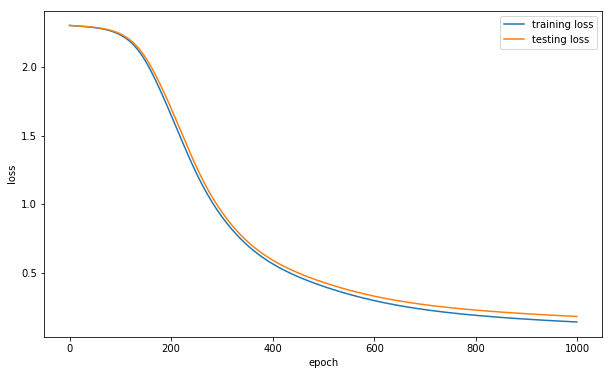

In [39]:
plot_loss_curve(training_loss_list, testing_loss_list)

## 更换数据集

我们换一个数据集，使用MNIST手写数字数据集。

MNIST是最有名的手写数字数据集之一，主页：http://yann.lecun.com/exdb/mnist/

MNIST手写数字数据集有60000个样本组成的训练集，10000个样本组成的测试集，是NIST的子集。数字的尺寸都是归一化后的，且都在图像的中央。可以从上方的主页下载。

我们使用的数据集是kaggle手写数字识别比赛中的训练集。数据集一共42000行，785列，其中第1列是标记，第2列到第785列是图像从左上角到右下角的像素值。图像大小为28×28像素，单通道的灰度图像。

我们使用的是kaggle提供的MNIST手写数字识别比赛的训练集。这个数据集还是手写数字的图片，只不过像素变成了 $28 \times 28$，图片的尺寸变大了，而且数据集的样本量也大了。我们取30%为测试集，70%为训练集。训练集样本数有29400个，测试集12600个。

In [40]:
#X.shape

In [41]:
import pandas as pd

data = pd.read_csv('data/kaggle_mnist/mnist_train.csv')
X = data.values[:, 1:].astype('float32')
Y = data.values[:, 0]

trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.3, random_state = 32)

trainY_mat = np.zeros((len(trainY), 10))
trainY_mat[np.arange(0, len(trainY), 1), trainY] = 1

testY_mat = np.zeros((len(testY), 10))
testY_mat[np.arange(0, len(testY), 1), testY] = 1

In [42]:
len(X)

42000

In [43]:
trainX.shape, trainY.shape, trainY_mat.shape, testX.shape, testY.shape, testY_mat.shape

((29400, 784), (29400,), (29400, 10), (12600, 784), (12600,), (12600, 10))

绘制训练集前10个图像

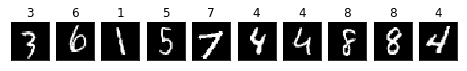

In [44]:
_, figs = plt.subplots(1, 10, figsize=(8, 4))
for f, img, lbl in zip(figs, trainX[:10], trainY[:10]):
    f.imshow(img.reshape((28, 28)), cmap = 'gray')
    f.set_title(lbl)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)

## test：请你使用kaggle MNIST数据集，根据下表设定各个超参数，计算测试集上的精度，绘制损失值变化曲线，填写下表

任务流程：
1. 对数据集进行标准化处理
2. 设定学习率和迭代轮数进行训练
3. 计算测试集精度
4. 绘制曲线

###### 双击此处填写

精度保留4位小数；训练时间单位为秒，保留两位小数。

隐藏层单元数 | 学习率 | 迭代轮数 | 测试集精度 | 训练时间(秒)
-|-|-|-
100 | 0.1 | 50 | 0.8076 |138.06
100 | 0.1 | 100 |0.8872| 276.82
100 | 0.1 | 150 | 0.8992 | 416.42
100 | 0.1 | 500 | 0.9199 | 1404.33
100 | 0.01 | 500 |0.8122|1421.63

In [45]:
# YOUR CODE HERE
#标准化处理
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
trainX = s.fit_transform(trainX)
testX = s.transform(testX)


In [46]:
#第一个感知机
start_time = time()

h = 100
K = 10
parameters = initialize(h, K)
print(parameters['W1'].shape) 
print(parameters['b1'].shape) 
print(parameters['W2'].shape)
print(parameters['b2'].shape) 

(784, 100)
(1, 100)
(100, 10)
(1, 10)


In [47]:
training_loss_list, testing_loss_list = train(trainX, trainY_mat, testX, testY_mat, parameters, 50, 0.1, False)

end_time = time()
print('training time: %s s'%(end_time - start_time))

training time: 176.42016005516052 s


In [48]:
#预测
prediction = predict(testX, parameters)
accuracy_score(prediction, testY)

0.80769841269841269

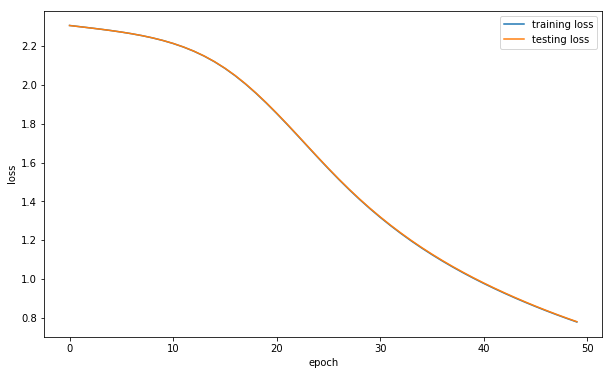

In [49]:
#绘图
plot_loss_curve(training_loss_list, testing_loss_list)

training time: 337.819313287735 s


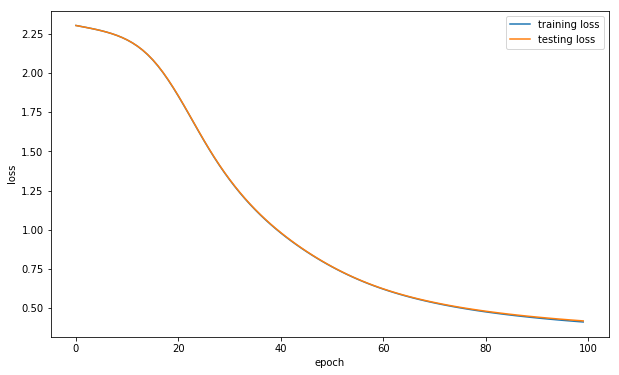

In [50]:
#第二个感知机
start_time = time()

h = 100
K = 10
parameters = initialize(h, K)

training_loss_list, testing_loss_list = train(trainX, trainY_mat, testX, testY_mat, parameters, 100, 0.1, False)

end_time = time()
print('training time: %s s'%(end_time - start_time))

#预测
prediction = predict(testX, parameters)
accuracy_score(prediction, testY)

#绘图
plot_loss_curve(training_loss_list, testing_loss_list)

In [51]:
print(accuracy_score(prediction, testY))

0.887222222222


training time: 509.6497700214386 s
0.899285714286


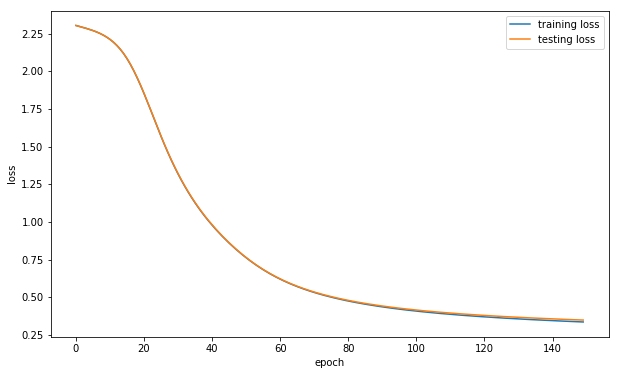

In [ ]:
#第三个感知机
start_time = time()

h = 100
K = 10
parameters = initialize(h, K)

training_loss_list, testing_loss_list = train(trainX, trainY_mat, testX, testY_mat, parameters, 150, 0.1, False)

end_time = time()
print('training time: %s s'%(end_time - start_time))

#预测
prediction = predict(testX, parameters)
print(accuracy_score(prediction, testY))

#绘图
plot_loss_curve(training_loss_list, testing_loss_list)

In [ ]:
#第四个感知机
start_time = time()

h = 100
K = 10
parameters = initialize(h, K)

training_loss_list, testing_loss_list = train(trainX, trainY_mat, testX, testY_mat, parameters, 500, 0.1, False)

end_time = time()
print('training time: %s s'%(end_time - start_time))

#预测
prediction = predict(testX, parameters)
print(accuracy_score(prediction, testY))

#绘图
plot_loss_curve(training_loss_list, testing_loss_list)

In [ ]:
#第五个感知机
start_time = time()

h = 100
K = 10
parameters = initialize(h, K)

training_loss_list, testing_loss_list = train(trainX, trainY_mat, testX, testY_mat, parameters, 500, 0.01, False)

end_time = time()
print('training time: %s s'%(end_time - start_time))

#预测
prediction = predict(testX, parameters)
accuracy_score(prediction, testY)

#绘图
plot_loss_curve(training_loss_list, testing_loss_list)

In [ ]:
print(accuracy_score(prediction, testY))